In [40]:
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import json
import os
import shutil

DEBUG = False

In [213]:
LodeRunnerPaths = sorted(glob.glob("/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/*.bmp"))
print(LodeRunnerPaths)

['/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/megaman_1_1.bmp', '/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/megaman_1_10.bmp', '/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/megaman_1_2.bmp', '/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/megaman_1_3.bmp', '/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/megaman_1_4.bmp', '/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/megaman_1_5.bmp', '/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/megaman_1_6.bmp', '/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/megaman_1_7.bmp', '/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/megaman_1_8.bmp', '/home/surfytom/Projects/Dissertation/Repos/tile_embeddings/data/vglc/MegaMan/megaman_1_9.bmp']


In [214]:
level1 = cv2.imread(LodeRunnerPaths[0])

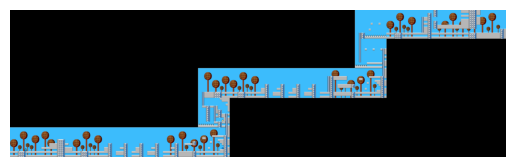

In [215]:
plt.axis(False)
plt.imshow(cv2.cvtColor(level1, cv2.COLOR_BGR2RGB))

In [ ]:
def ResizeLevel(levelImage, tileSize, kernelSize, heightOffset=0, widthOffset=0):

    if levelImage.ndim > 3 or levelImage.ndim < 2:
        print(f"Level Image has ({levelImage.ndim}) dimensions which is not valid. Valid dimensions: 2 (text files) or 3 (images)")
        return

    height, width = levelImage.shape[:2]

    if DEBUG:
        print(height, " ", width)
        print(height % 16, " ", width % 16)

    startPosition = kernelSize % 2

    boxHeight = tileSize * kernelSize
    boxWidth = tileSize * kernelSize
    
    originPoint = [heightOffset, widthOffset]

    if DEBUG:
        print(startPosition)

    padding = ((kernelSize // 2) * 2) if kernelSize > 1 else 0
    
    widthWithKernel = (width // tileSize) - padding
    heightWithKernel = (height // tileSize) - padding

    if DEBUG:
        print(kernelSize)
        print(kernelSize % 2)
        print(((kernelSize % 2) * 2))

        print(heightWithKernel, " ", widthWithKernel)

    tileGroupImages = []

    for i in range(heightWithKernel):
        for j in range(widthWithKernel):
            
            if levelImage.ndim == 2:
                cropped = levelImage[originPoint[0]:originPoint[0]+boxHeight, originPoint[1]:originPoint[1]+boxWidth]

                if DEBUG:
                    print("origin1: ", originPoint[0], " origin2: ", originPoint[1])
                    print(cropped)
            else:
                cropped = cv2.resize(levelImage[originPoint[0]:originPoint[0]+boxHeight, originPoint[1]:originPoint[1]+boxWidth, :], (boxHeight*2, boxWidth*2), interpolation=cv2.INTER_NEAREST)

            tileGroupImages.append(cropped)

            originPoint[1] += tileSize
        
        originPoint[0] += tileSize
        originPoint[1] = widthOffset

    # if os.path.isdir("testdata"):
    #     shutil.rmtree("testdata")
    
    # os.mkdir("testdata")

    # for i, tile in enumerate(tileGroupImages):
    #     cv2.imwrite(f"testdata/{i}-{j}.png", tile)

    return np.array(tileGroupImages)

In [3]:
def LoadLevelTextFile(filePath):
    
    tileArray = []

    with open(filePath, "r") as f:
        for line in f:
            tileArray.append(list(line.rstrip("\n")))
    
    tileArray = np.array(tileArray)

    return tileArray

In [4]:
def TextTileToImage(tileArray, tileSize, spritePath, savePath=None):

    outputImage = np.empty((tileSize*tileArray.shape[0], tileSize*tileArray.shape[1], 3), dtype=np.uint8)

    fileName = ""

    for i, row in enumerate(tileArray):
        for j, tile in enumerate(row):

            tile = '@' if tile == '.' else tile
            fileName += tile

            tileImage = cv2.cvtColor(cv2.imread(f"{spritePath}/{tile}.png"), cv2.COLOR_BGR2RGB)
            outputImage[i*tileSize:(i+1)*tileSize, j*tileSize:(j+1)*tileSize] = tileImage

    if savePath:
        cv2.imwrite(f"{savePath}/{fileName}.png", outputImage)

    return outputImage

In [8]:
def GetAffordances(tileArray, affordanceDictionary, centerTileOnly=False):

    if centerTileOnly:
        centerX, centerY = tileArray.shape[0] // 2, tileArray.shape[1] // 2
        #print("Tile: ", tileArray[centerX, centerY], " affordance: ", affordanceDictionary[tileArray[centerX, centerY]])
        return affordanceDictionary[tileArray[centerX, centerY]]
    
    outputAffordancs = []

    for i, row in enumerate(tileArray):
        outputAffordancs.append([])
        for j, tile in enumerate(row):
            outputAffordancs[i].append(affordanceDictionary[tile])


    return outputAffordancs

In [56]:
loderunnerTextLevelPaths = glob.glob("../data/vglc/Lode Runner/Processed/*.txt")
kidicTextLevelPaths = glob.glob("../data/vglc/Kid Icarus/Processed/*.txt")
megamanTextLevelPaths = glob.glob("../data/vglc/MegaMan/megaman_[0-9]_[0-9].txt") + glob.glob("../data/vglc/MegaMan/megaman_[0-9]_[0-9][0-9].txt")
smbTextLevelPaths = glob.glob("../data/vglc/Super Mario Bros/Processed_Fixed/*.txt")
lozTextLevelPaths = glob.glob("../data/vglc/The Legend of Zelda/Processed/tloz[0-9]_[0-9].txt")

allLevelPaths = [
    [kidicTextLevelPaths, "kidicarus", "../data/vglc/Kid Icarus/KidIcarus.json"], 
    [loderunnerTextLevelPaths, "loderunner", "../data/vglc/Lode Runner/Loderunner.json"], 
    [megamanTextLevelPaths, "megaman", "../data/vglc/MegaMan/megaman.json"], 
    [smbTextLevelPaths, "supermariobros", "../data/vglc/Super Mario Bros/smb.json"], 
    [lozTextLevelPaths, "thelegendofzelda", "../data/vglc/The Legend of Zelda/loz.json"]
]

In [61]:
totalUniqueCombos = 0
allTiles = []
allAffordances = []

for (gameLevelPaths, folderName, affordanceJsonPath) in allLevelPaths:
    savePath = f"../data/tomData/uniquetiles/{folderName}"
    print(f"Folder Name: {folderName}")

    affordanceJson = None

    with open(affordanceJsonPath, "r") as f:
        affordanceJson = json.load(f)["tiles"]
    
    textLevels = []
    affordances = []

    for textLevel in gameLevelPaths:
        print(textLevel)
        t = LoadLevelTextFile(textLevel)
        print("Loaded Level Shape: ", t.shape)
        print(f"Possible 3x3 Combinations for level: {(t.shape[0]-2) * (t.shape[1]-2)}")
        t = ResizeLevel(t, 1, 3)
        print("Processed Level Shape: ", t.shape)

        textLevels += t.tolist()
    
    textLevelGroups = np.array(textLevels)
    print(f"Text levels combined shape {folderName}: {textLevelGroups.shape}")

    textLevelGroups = np.unique(textLevelGroups, axis=0)
    totalUniqueCombos += textLevelGroups.shape[0]
    print(f"Unique Combinations {folderName}: {textLevelGroups.shape}\n")

    allTiles.append(textLevelGroups.tolist())
    allAffordances.append([GetAffordances(kernal, affordanceJson, True) for kernal in textLevelGroups])

print(f"Total Unique Combos of Tiles: {totalUniqueCombos}")

Folder Name: kidicarus
../data/vglc/Kid Icarus/Processed/kidicarus_6.txt
Loaded Level Shape:  (233, 16)
Possible 3x3 Combinations for level: 3234
Processed Level Shape:  (3234, 3, 3)
../data/vglc/Kid Icarus/Processed/kidicarus_5.txt
Loaded Level Shape:  (206, 16)
Possible 3x3 Combinations for level: 2856
Processed Level Shape:  (2856, 3, 3)
../data/vglc/Kid Icarus/Processed/kidicarus_1.txt
Loaded Level Shape:  (173, 16)
Possible 3x3 Combinations for level: 2394
Processed Level Shape:  (2394, 3, 3)
../data/vglc/Kid Icarus/Processed/kidicarus_3.txt
Loaded Level Shape:  (281, 16)
Possible 3x3 Combinations for level: 3906
Processed Level Shape:  (3906, 3, 3)
../data/vglc/Kid Icarus/Processed/kidicarus_4.txt
Loaded Level Shape:  (159, 16)
Possible 3x3 Combinations for level: 2198
Processed Level Shape:  (2198, 3, 3)
../data/vglc/Kid Icarus/Processed/kidicarus_2.txt
Loaded Level Shape:  (203, 16)
Possible 3x3 Combinations for level: 2814
Processed Level Shape:  (2814, 3, 3)
Text levels combi

In [62]:
gameNames = ['kidicarus', 'loderunner', 'megaman', 'supermariobros', 'thelegendofzelda']

In [63]:
dataframes = []
resultDf = None
for i, gameName in enumerate(gameNames):

    tempDataframe = pd.DataFrame()

    tileSeries = pd.Series(allTiles[i])
    affordanceSeries = pd.Series(allAffordances[i])

    tempDataframe["tiles"] = tileSeries
    tempDataframe["affordances"] = affordanceSeries

    print(tempDataframe.head())

    tempDataframe.insert(0, 'gamename', gameName)

    print(tempDataframe.head())

    dataframes.append(tempDataframe)

resultDf = pd.concat(dataframes)
print(resultDf.head())

                               tiles affordances
0  [[#, #, #], [#, #, #], [#, #, #]]     [solid]
1  [[#, #, #], [#, #, #], [#, #, -]]     [solid]
2  [[#, #, #], [#, #, #], [#, #, T]]     [solid]
3  [[#, #, #], [#, #, #], [#, -, -]]     [solid]
4  [[#, #, #], [#, #, #], [#, D, -]]     [solid]
    gamename                              tiles affordances
0  kidicarus  [[#, #, #], [#, #, #], [#, #, #]]     [solid]
1  kidicarus  [[#, #, #], [#, #, #], [#, #, -]]     [solid]
2  kidicarus  [[#, #, #], [#, #, #], [#, #, T]]     [solid]
3  kidicarus  [[#, #, #], [#, #, #], [#, -, -]]     [solid]
4  kidicarus  [[#, #, #], [#, #, #], [#, D, -]]     [solid]
                               tiles            affordances
0  [[#, #, #], [#, #, #], [#, #, #]]  [passable, climbable]
1  [[#, #, #], [#, #, #], [#, #, .]]  [passable, climbable]
2  [[#, #, #], [#, #, #], [#, #, E]]  [passable, climbable]
3  [[#, #, #], [#, #, #], [#, #, G]]  [passable, climbable]
4  [[#, #, #], [#, #, #], [#, #, b]]  [passabl

In [64]:
resultDf.to_csv('../data/tomData/unshuffled3x3tiles.csv')
randomState = 1
train, test = train_test_split(resultDf, test_size=0.1, random_state=randomState, shuffle=True)
train.to_csv(f'../data/tomData/shuffled3x3tilestrain_rs{randomState}.csv')
test.to_csv(f'../data/tomData/shuffled3x3tilestest_rs{randomState}.csv')

# Testing Duplicates from Original Game Data

In [ ]:
game_data_path="../data/game_data.csv"
data=pd.read_csv(game_data_path)

In [16]:
gameList = data["game_identifier"].unique().tolist()
gameList

['kid_icarus', 'smb', 'lode_runner', 'loz', 'megaman']

In [21]:
kidIcDf = data.loc[data["game_identifier"] == gameList[0]]
smbDf = data.loc[data["game_identifier"] == gameList[1]]
lodeRunnerDf = data.loc[data["game_identifier"] == gameList[2]]
lozDf = data.loc[data["game_identifier"] == gameList[3]]
megaManDf = data.loc[data["game_identifier"] == gameList[4]]

gamesDfs = [kidIcDf, smbDf, lodeRunnerDf, lozDf, megaManDf]

In [59]:
for i, gameDf in enumerate(gamesDfs):
    print(gameList[i])
    print(gameDf.shape[0])
    noDups = gameDf.drop_duplicates()
    print(noDups.shape[0])
    print(gameDf.shape[0] - gameDf[gameDf["context_string"].str.contains(" ")].shape[0])
    print(gameDf.shape[0] - gameDf[gameDf["context_string"].str.contains(" |X", regex=True)].shape[0])
    print(gameDf.shape[0] - gameDf[gameDf["context_string"].str.contains(" |x", regex=True)].shape[0])
    print("")

kid_icarus
1011
1011
798
798
798

smb
1999
1999
1703
922
1703

lode_runner
17551
17551
15151
15151
15151

loz
1662
1662
1626
1626
1626

megaman
3171
3171
2937
2937
2937



In [42]:
gamesDfs[0].to_csv('test.csv', index=False)

In [43]:
a = gamesDfs[0][["context_string"]]

In [46]:
a.shape[0] - a[a["context_string"].str.contains(" ")].shape[0]

798

In [338]:
textLevelPaths = glob.glob("../data/vglc/Lode Runner/Processed/*.txt")
textLevels = np.array([LoadLevelTextFile(textLevel) for textLevel in textLevelPaths])
print(textLevels.shape)
textLevelGroups = np.array([ResizeLevel(textLevel, 1, 3, textFile=True) for textLevel in textLevels])
print(textLevelGroups.shape)
textLevelGroups = textLevelGroups.reshape((textLevelGroups.shape[0]*textLevelGroups.shape[1], 3, 3))
textLevelGroups = np.unique(textLevelGroups, axis=0)
print(textLevelGroups.shape)

(150, 22, 32)
(150, 600, 3, 3)
(15151, 3, 3)
